In [ ]:
!pip install langgraph

In [1]:
import boto3
from botocore.config import Config

def converse_with_bedrock(model_client, sys_prompt, usr_prompt, model_id):
    temperature = 0
    top_p = 0.1
    top_k = 1
    inference_config = {"temperature": temperature, "topP": top_p}
    additional_model_fields = {"top_k": top_k}
    response = model_client.converse(
        modelId=model_id, 
        messages=usr_prompt, 
        system=sys_prompt,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )
    return response['output']['message']['content'][0]['text']

def init_boto3_client(region: str):
    retry_config = Config(
        region_name=region,
        retries={"max_attempts": 10, "mode": "standard"}
    )
    return boto3.client("bedrock-runtime", region_name=region, config=retry_config)

def create_prompt(sys_template, user_template, **kwargs):
    sys_prompt = [{"text": sys_template.format(**kwargs)}]
    usr_prompt = [{"role": "user", "content": [{"text": user_template.format(**kwargs)}]}]
    return sys_prompt, usr_prompt


In [2]:
import os
from py2neo import Graph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Graph()
region_name = "us-west-2"
boto3_client = init_boto3_client(region_name)

In [3]:
from typing import TypedDict, List, Optional, Any

class TraverseState(TypedDict, total=False):
    parent_id: Optional[int]
    parent_name: Optional[str]
    child_level: int
    selected_child_ids: List[int]
    child_names: List[str]
    next_action: str

class GraphState(TypedDict, total=False):
    high_priority_model: str
    low_priority_model: str
    region_name: str
    question: str
    subgraph: str
    target_node: List[int]
    next_step: str
    parent_id: int
    parent_name: str
    content: str
    contents_length: int
    search_type: str
    traverse_state: List[TraverseState]
    searching_scheme: str
    language: str
    status: str
    k: int
    answer: str

In [4]:
def select_subgraph(state: GraphState) -> GraphState:
    question = state['question']  
    query = """
        MATCH (n:Title {level: "1"})
        RETURN n.value, id(n) as node_id
    """
    results = graph.run(query)
    subgraph_list = [(record["n.value"], record["node_id"]) for record in results]
    subgraph_list_with_number = [f"{i}. {subgraph[0]}" for i, subgraph in enumerate(subgraph_list)]

    sys_prompt_template = """ 
    You are an expert engineer well-versed in AWS manual documents. 
    Your task is to select the most appropriate manual document name for the user's question. 
    If there are no relevant documents, provide an empty list (""). """

    usr_prompt_template = """ 
    Please select the single most relevant document name for the given question.

    #Question: {question}

    #Document List: {subgraph_list_with_number}

    #Response Format: Provide only the index number of the selected document (omit any preamble) """
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, subgraph_list_with_number=subgraph_list_with_number)
    
    model_id = state['low_priority_model']
    selected_id = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
    print(selected_id)
    try:
        if selected_id == "":
            return GraphState(target_node=[], subgraph="Not Found", next_step="global_search")

        else: 
            selected_subgraph_id = subgraph_list[int(selected_id)][1]
            print("Selected:", subgraph_list[int(selected_id)][0])
            return GraphState(target_node=[selected_subgraph_id], subgraph=subgraph_list[int(selected_id)][0], next_step="traverse_subgraph")
    except:
        return GraphState(target_node=[], subgraph="Not Found", next_step="global_search")

In [5]:
def traverse_subgraph(state: GraphState) -> GraphState:
    question = state['question']
    
    if not state['traverse_state']:
        parent_id = state['target_node'][0]
    else:
        parent_id = state['traverse_state'][-1]['selected_child_ids'][0]
    subgraph = state['subgraph']

    query = """
        MATCH (n)
        WHERE id(n) = $parent_id
        OPTIONAL MATCH (n)-[:HAS_CHILD]->(c)
        RETURN n.value as parent_name, c.level as child_level, c.value as child_name, id(c) as child_id
    """
    params = {"parent_id": parent_id}
    query_results = graph.run(query, params)

    parent_name = None
    child_level = None
    child_list = []
    child_names = []

    for record in query_results:
        if parent_name is None:
            parent_name = record["parent_name"]
        if child_level is None:
            child_level = record["child_level"]
        if record["child_name"] is not None:
            child_list.append((record["child_name"], record["child_id"]))
            child_names.append(record["child_name"])

    print(f"Traversing '{parent_name}'...")

    if not child_list:
        print("No child. Proceed to 'get_contents'...")
        traverse_state: TraverseState = {
            "parent_id": parent_id,
            "parent_name": parent_name,
            "child_level": -1,
            "selected_child_ids": [],
            "child_names": [],
            "next_action": "get_contents"
        }
        return GraphState(traverse_state=state['traverse_state'] + [traverse_state])

    child_list_with_number = [f"{i}. {child}" for i, child in enumerate(child_list)]
    csv_list_response_format = "Your response should be a list of comma separated values, eg: `foo, bar` or `foo,bar`"
    sys_prompt_template = """ You are an AI assistant specialized in AWS documentation, particularly for Bedrock services. Your task is to identify the most relevant sub-menu(s) from the provided <{subgraph}> manual to answer the user's question about AWS Bedrock.

    Instructions:
        1. Carefully analyze the given list of sub-menus.
        2. Select the menu item(s) most directly related to the user's question.
        3. Respond with the index number(s) of the selected menu item(s), starting from 0.

    Selection criteria:
        1. Prioritize menus that directly address the specific topic or feature mentioned in the question.
        2. Look for keywords related to the question, such as "custom models", "Bedrock", "implementation", etc.
        3. Prefer detailed, specific menu items over general or introductory ones.
        4. If no menu item is sufficiently relevant, it's acceptable to not make a selection.

    Important: Your response should ONLY include the index number(s) of the selected menu item(s), nothing else. """

    usr_prompt_template = """ 
    Question: {question}

    Menu list: 
    {child_list_with_number}

    Response format: {csv_list_response_format} """

    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, subgraph=subgraph, question=question, child_list_with_number=child_list_with_number, csv_list_response_format=csv_list_response_format)
    model_id = state['high_priority_model']
    selected_ids = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
    
    try:
        selected_id_list = [int(id.strip()) for id in selected_ids.split(',') if id.strip().isdigit()]

        if not selected_id_list:
            traverse_state: TraverseState = {
                "parent_id": parent_id,
                "parent_name": parent_name,
                "child_level": -1,
                "selected_child_ids": [],
                "child_names": [],
                "next_action": "get_contents"
            }
            return GraphState(traverse_state=state['traverse_state'] + [traverse_state])

        selected_child_ids = [child_list[id][1] for id in selected_id_list if id < len(child_list)]
        selected_child_names = [child_list[id][0] for id in selected_id_list if id < len(child_list)]
        traverse_state: TraverseState = {
            "parent_id": parent_id,
            "parent_name": parent_name,
            "child_level": child_level,
            "selected_child_ids": selected_child_ids,
            "child_names": selected_child_names,
            "next_action": "traverse_subgraph"
        }
        return GraphState(traverse_state=state['traverse_state'] + [traverse_state])

    except Exception as e:
        traverse_state: TraverseState = {
            "parent_id": parent_id,
            "parent_name": parent_name,
            "child_level": -1,
            "selected_child_ids": [],
            "child_names": [],
            "next_action": "get_contents"
        }
        return GraphState(traverse_state=state['traverse_state'] + [traverse_state])

In [6]:
def get_contents(state: GraphState) -> GraphState:
    parent_id = state['traverse_state'][-1]['parent_id']
    k = state['k']
    print(k)

    count_query = """
        MATCH (n)-[:HAS_CONTENTS]->(c)
        WHERE id(n) = $parent_id
        RETURN count(c) as contents_length, n.value as parent_name
    """
    params = {"parent_id": parent_id}
    count_result = graph.run(count_query, params).data()[0]
    contents_length = count_result['contents_length']
    parent_name = count_result['parent_name']
    print(f"Num Documents: {contents_length}")

    if contents_length <= k * 2:
        search_type = "get_short_documents"
        content_query = """
            MATCH (n)-[:HAS_CONTENTS]->(c)
            WHERE id(n) = $parent_id
            RETURN c.text
            ORDER BY c.order
            LIMIT $k
        """
        params = {"parent_id": parent_id, "k": k}
        content_results = graph.run(content_query, params)
        contents = [record["c.text"] for record in content_results]
        context = " ".join(contents)

    else:
        search_type = "node_level_search"
        context = ""

    new_state = state.copy()
    new_state.update({
        'parent_id': parent_id,
        'parent_name': parent_name,
        'content': context,
        'contents_length': contents_length,
        'search_type': search_type,
        'k': k
    })

    return new_state

In [7]:
from langchain_aws import BedrockEmbeddings
from langchain.vectorstores import Neo4jVector


def node_level_search(state: GraphState) -> GraphState:
    question = state['question']  
    subgraph = state['subgraph']
    parent_id = state['parent_id']
    parent_name = state['parent_name']
    language = state['language']
    searching_scheme = state['searching_scheme']
    k = state['k']
    
    csv_list_response_format = "Your response should be a list of comma separated values, eg: `foo, bar` or `foo,bar`"
    if searching_scheme == "vector":
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, please create a question suitable for vector search to find documents in the manual. ({language})

        Note:
        - Generate the most relevant and characteristic question considering both the document name and the user's question.
        - Prefer natural language questions that well represent specific content of the document.
        """

        usr_prompt_template = """
        #Target document name:
        {subgraph}

        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """

        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, subgraph=subgraph, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)

        index_name = "content_embedding_index"
        embeddings = BedrockEmbeddings(model_id="cohere.embed-multilingual-v3", region_name=state['region_name'])
        vector_store = Neo4jVector.from_existing_index(
            embedding=embeddings,
            index_name=index_name,
            node_label="Content",
            text_node_property="text", 
            embedding_node_property="embedding"
        )

        question_embedding = embeddings.embed_query(keywords)

        vector_search_query = """
            MATCH (parent)-[:HAS_CONTENTS]->(child:Content)
            WHERE id(parent) = $parent_id
            WITH child
            CALL db.index.vector.queryNodes($index_name, $k, $question_embedding) YIELD node, score
            WHERE node = child
            RETURN id(node) AS node_id, node.text AS text, score
            ORDER BY score DESC
            LIMIT $k
        """

        params = {
            "parent_id": parent_id,
            "question_embedding": question_embedding,
            "k": k,
            "index_name": index_name
        }

        search_results = vector_store.query(vector_search_query, params=params)
        
    else:
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, extract one core keyword from the manual.
        The keyword must meet the following conditions:
        1. No special characters like '_', '-' in the keyword (e.g., respond with 'custom model' instead of 'custom_model')
        2. Choose the most appropriate word within the given document name that fits the context of the question (no need to include the document name in the keyword)
        3. Select specific words that represent the particular function or concept you're searching for, rather than content already included in the document name
        4. Provide the keyword in {language}

        Note:
        - Consider both the document name and the question to select the most relevant and characteristic word within that document.
        - Prefer words that represent specific content of the document rather than overly general terms.
        """

        usr_prompt_template = """
        #Target document name:
        {parent_name}

        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, parent_name=parent_name, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
    

        if searching_scheme == "full_text":
            search_query = """MATCH (parent)-[:HAS_CONTENTS]->(child)
                WHERE id(parent) = $parent_id
                WITH child
                CALL db.index.fulltext.queryNodes("Search_Content_by_FullText", $keywords) YIELD node, score
                WHERE node = child
                RETURN node.text as text, score
                ORDER BY score DESC
                LIMIT $k
            """
        elif searching_scheme == "keyword":
            search_query = """MATCH (parent)-[:HAS_CONTENTS]->(child)
                WHERE id(parent) = $parent_id
                WITH child, $keywords AS keyword
                WHERE child.text CONTAINS keyword
                RETURN child.text AS text, 
                    size(split(toLower(child.text), toLower(keyword))) - 1 AS score
                ORDER BY score DESC
                LIMIT $k
            """
        
        params = {"parent_id": parent_id, "keywords": keywords, "k": k}
        search_results = graph.run(search_query, params)
        
    content = "\n\n\n".join(f"{record['text']} (Score: {record['score']})" for record in search_results)
    return GraphState(content=content)

In [8]:
def check_relevance(state: GraphState) -> GraphState:
    question = state['question']
    content = state['content']
    contents_length = state['contents_length']
    search_type = state['search_type']
    parent_name = state['parent_name']
    k = state['k']
    optional_prompt1 = ""
    optional_prompt2 = ""
    
    if search_type == "get_short_documents" and contents_length > k:
        optional_prompt1 = "- Preliminary information matches the question's intent but further content needs to be checked: 'Partial'"
        optional_prompt2 = "or `Partial`"

    sys_prompt_template = """
    You are a skilled data analyst. Your task is to determine whether the given question can be answered using only the provided preliminary information, based on the following criteria:

    Judgment criteria:
    1. Do the key keywords of the question appear in the document name or preliminary information?
    2. Does it contain the specific information we're trying to find out?

    Response method:
    - If the document name and preliminary information are irrelevant to the question: 'None'
    - If the question can be answered with the preliminary information alone: 'Complete'
    {partial1}

    Skip any preamble and respond only with `None` or `Complete`{partial2}.
    """

    usr_prompt_template = """
    #Preliminary information (Document name: {parent_name})
    {context}

    #Question: {question}
    """

    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, partial1=optional_prompt1, partial2=optional_prompt2, parent_name=parent_name, question=question, context=content)
    model_id = state['high_priority_model']
    status = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
    return GraphState(status=status)

In [9]:
def get_sibling_contents(state: GraphState) -> GraphState:
    
    content = state['content']
    parent_id = state['parent_id']
    k = state['k']

    content_query = """
        MATCH (n)-[:HAS_CONTENTS]->(c)
        WHERE id(n) = $parent_id AND c.order >= $order_pos
        RETURN c.text
        ORDER BY c.order
        LIMIT $k
    """       
    trial = 1
    order_pos = k * trial
    params = {"parent_id": parent_id, "k": k, "order_pos": order_pos} 

    content_results = graph.run(content_query, params)
    sibling_content = [record["c.text"] for record in content_results]
    content = " ".join([content] + sibling_content)
    
    return GraphState(content=content)

In [10]:
from langchain_aws import BedrockEmbeddings
from langchain.vectorstores import Neo4jVector

def subgraph_level_search(state: GraphState) -> GraphState:
    question = state['question']
    
    subgraph = state['subgraph']
    language = state['language']
    k = state['k']
    searching_scheme = state['searching_scheme']

    csv_list_response_format = "Your response should be a list of comma separated values, eg: `foo, bar` or `foo,bar`"
    if searching_scheme == "vector":
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, please create a question suitable for vector search to find documents in the manual. ({language})

        Note:
        - Generate the most relevant and characteristic question considering both the document name and the user's question.
        - Prefer natural language questions that well represent specific content of the document.
        """

        usr_prompt_template = """
        #Target document name:
        {subgraph}

        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """

        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, subgraph=subgraph, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
        print(keywords)
        index_name = "content_embedding_index"

        embeddings = BedrockEmbeddings(model_id="cohere.embed-multilingual-v3", region_name=state['region_name'])
        question_embedding = embeddings.embed_query(keywords)

        vector_search_query = """
        MATCH (root:Title {level: "1", value: $subgraph})
        MATCH (root)-[:HAS_CHILD*0..]->(title:Title)-[:HAS_CONTENTS]->(content:Content)

        CALL db.index.vector.queryNodes($index_name, $k, $question_embedding) YIELD node, score
        WHERE node = content

        RETURN node.text AS text, score
        ORDER BY score DESC
        LIMIT $k
        """

        params = {
            "subgraph": subgraph,
            "question_embedding": question_embedding,
            "k": k,
            "index_name": index_name
        }

        vector_store = Neo4jVector.from_existing_index(
            embedding=embeddings,
            index_name=index_name,
            node_label="Content",
            text_node_property="text", 
            embedding_node_property="embedding"
        )

        search_results = vector_store.query(vector_search_query, params=params)

    else:
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, extract one core keyword from the manual.
        The keyword must meet the following conditions:
        1. No special characters like '_', '-' in the keyword (e.g., respond with 'custom model' instead of 'custom_model')
        2. Choose the most appropriate word within the given document name that fits the context of the question (no need to include the document name in the keyword)
        3. Select specific words that represent the particular function or concept you're searching for, rather than content already included in the document name
        4. Provide the keyword in {language}

        Note:
        - Consider both the document name and the question to select the most relevant and characteristic word within that document.
        - Prefer words that represent specific content of the document rather than overly general terms.
        """

        usr_prompt_template = """
        #Target document name:
        {subgraph}

        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, subgraph=subgraph, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
    
        
        if searching_scheme == "full_text":
            search_query = """
                MATCH (root:Title {level: "1", value: $subgraph})
                MATCH (root)-[:HAS_CHILD*0..]->(title:Title)-[:HAS_CONTENTS]->(content:Content)

                CALL db.index.fulltext.queryNodes("Search_Content_by_FullText", $keywords) YIELD node, score
                WHERE node = content

                RETURN node.text as text, score, title.name as title_name, title.level as title_level
                ORDER BY score DESC
                LIMIT $k
            """
        elif searching_scheme == "keyword":
            search_query = """
                MATCH (root:Title {level: "1", value: $subgraph})
                MATCH (root)-[:HAS_CHILD*0..]->(title:Title)-[:HAS_CONTENTS]->(content:Content)
                WITH content, title, $keywords AS keyword
                WHERE content.text CONTAINS keyword
                RETURN content.text AS text, 
                    size(split(toLower(content.text), toLower(keyword))) - 1 AS score,
                    {
                        title: title.name,
                        level: title.level,
                        value: title.value
                    } AS metadata
                ORDER BY score DESC
                LIMIT $k
            """
        
        params = { "subgraph": subgraph, "k": k, "keywords": keywords}
        search_results = graph.run(search_query, params)
        
    content = "\n\n\n".join(f"{record['text']} (Score: {record['score']})" for record in search_results)
    return GraphState(content=content)

In [11]:
from langchain_aws import BedrockEmbeddings
from langchain.vectorstores import Neo4jVector

def global_search(state: GraphState) -> GraphState:
    question = state['question']
    
    language = state['language']
    searching_scheme = state['searching_scheme']
    k = state['k']
    csv_list_response_format = "Your response should be a list of comma separated values, eg: `foo, bar` or `foo,bar`"
    
    if searching_scheme == "vector":
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, please create a question suitable for vector search to find documents in the manual. ({language})

        Note:
        - Generate the most relevant and characteristic question considering both the document name and the user's question.
        - Prefer natural language questions that well represent specific content of the document.
        """

        usr_prompt_template = """
        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """
    
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)

        index_name = "content_embedding_index"

        embeddings = BedrockEmbeddings(model_id="cohere.embed-multilingual-v3", region_name=state['region_name'])
        question_embedding = embeddings.embed_query(keywords)

        vector_search_query = """
        CALL db.index.vector.queryNodes($index_name, $k, $question_embedding) YIELD node, score
        WITH DISTINCT node, score
        WHERE node:Content
        RETURN node.text AS text, score
        ORDER BY score DESC
        """

        params = {
            "question_embedding": question_embedding,
            "k": k,
            "index_name": index_name
        }

        vector_store = Neo4jVector.from_existing_index(
            embedding=embeddings,
            index_name=index_name,
            node_label="Content",
            text_node_property="text", 
            embedding_node_property="embedding"
        )

        search_results = vector_store.query(vector_search_query, params=params)

    else:
        sys_prompt_template = """
        You are an expert engineer well-versed in AWS. Based on the user's question, extract one core keyword from the manual.
        The keyword must meet the following conditions:
        1. No special characters like '_', '-' in the keyword (e.g., respond with 'custom model' instead of 'custom_model')
        2. Choose the most appropriate word within the given document name that fits the context of the question (no need to include the document name in the keyword)
        3. Select specific words that represent the particular function or concept you're searching for, rather than content already included in the document name
        4. Provide the keyword in {language}

        Note:
        - Consider both the document name and the question to select the most relevant and characteristic word within that document.
        - Prefer words that represent specific content of the document rather than overly general terms.
        """

        usr_prompt_template = """
        #Question:
        {question}

        #Response format:
        {csv_list_response_format}
        """
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, language=language, question=question, csv_list_response_format=csv_list_response_format)
        model_id = state['low_priority_model'] 
        keywords = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)
        print(keywords)
        
        if searching_scheme == "full_text":
            search_query ="""
            CALL db.index.fulltext.queryNodes("Search_Content_by_FullText", $keywords) YIELD node, score
            WHERE node:Content
            OPTIONAL MATCH (title:Title)-[:HAS_CONTENTS]->(node)
            RETURN node.text as text, score, title.name as title_name, title.level as title_level
            ORDER BY score DESC
            LIMIT $k
            """
        elif searching_scheme == "keyword":
            search_query = """
            MATCH (content:Content)
            WITH content, $keywords AS keyword
            WHERE content.text CONTAINS keyword
            OPTIONAL MATCH (title:Title)-[:HAS_CONTENTS]->(content)
            RETURN content.text AS text, 
                size(split(toLower(content.text), toLower(keyword))) - 1 AS score,
                {
                    title: title.name,
                    level: title.level,
                    value: title.value
                } AS metadata
            ORDER BY score DESC
            LIMIT $k
            """
        
        params = {"k": k, "keywords": keywords}
        search_results = graph.run(search_query, params)
        
    content = "\n\n\n".join(f"{record['text']} (Score: {record['score']})" for record in search_results)
    return GraphState(content = content)

In [12]:
def generate_answer(state: GraphState) -> GraphState:
    question = state['question']
    context = state['content']

    # Prompt setting
    sys_prompt_template = """
    You are an expert engineer well-versed in AWS. 
    Generate an answer to the user's question using only the given preliminary information. """

    usr_prompt_template = """
    #Preliminary information: 
    {context}

    #User question:
    {question}
    """
    
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, context=context, question=question)
    model_id = state['high_priority_model'] 
    answer = converse_with_bedrock(boto3_client, sys_prompt, usr_prompt, model_id)

    return GraphState(answer=answer)

In [13]:
def next_step_by_subgraph(state: GraphState) -> str:
    return state['next_step']

def next_step_by_traverse_state(state: GraphState) -> str:
    if state['traverse_state'][-1]['next_action'] == "get_contents":
        next_action = "get_contents"
    else:
        next_action = "traverse_subgraph"
    return next_action

def next_step_by_context(state: GraphState) -> str:
    return state['search_type']

def next_step_by_relevance(state: GraphState) -> str:
    return state['status']

In [14]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("select_subgraph", select_subgraph)
workflow.set_entry_point("select_subgraph")
workflow.add_node("traverse_subgraph", traverse_subgraph)
workflow.add_node("get_contents", get_contents)
workflow.add_node("node_level_search", node_level_search)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("get_sibling_contents", get_sibling_contents)
workflow.add_node("subgraph_level_search", subgraph_level_search)
workflow.add_node("global_search", global_search)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "select_subgraph",
    next_step_by_subgraph,
    {
        "global_search": "global_search",
        "traverse_subgraph": "traverse_subgraph",
    }
)
workflow.add_conditional_edges(
    "traverse_subgraph",
    next_step_by_traverse_state,
    {
        "get_contents": "get_contents",
        "traverse_subgraph": "traverse_subgraph",
    }
)
workflow.add_conditional_edges(
    "get_contents",
    next_step_by_context,
    {
        "get_short_documents": "check_relevance",
        "node_level_search": "node_level_search"
    }
)
workflow.add_edge("node_level_search", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    next_step_by_relevance,
    {
        "Complete": "generate_answer",
        "Partial": "get_sibling_contents",
        "None": "subgraph_level_search"
    }
)
workflow.add_edge("get_sibling_contents", "generate_answer")
workflow.add_edge("subgraph_level_search", "generate_answer")
workflow.add_edge("global_search", "generate_answer")
workflow.add_edge("generate_answer", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

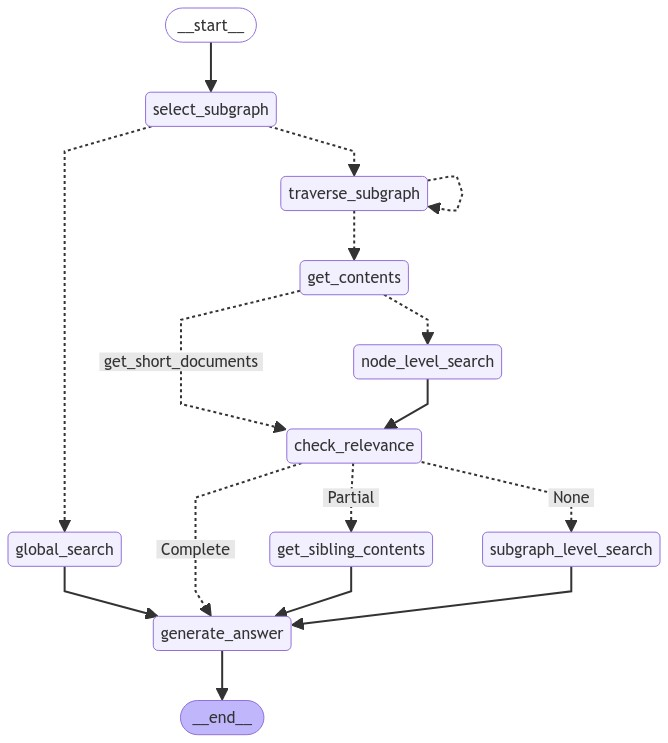

In [15]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    ) 
except:
    pass

In [ ]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

def run_query(question, high_priority_model, low_priority_model, region_name, searching_scheme, k, doc_language, app):
    config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})
    inputs = GraphState(
        question=question,
        high_priority_model=high_priority_model,
        low_priority_model=low_priority_model,
        region_name=region_name,
        searching_scheme=searching_scheme,
        k=k,
        language=doc_language,
        traverse_state=[]
    )

    pp = pprint.PrettyPrinter(width=200, compact=True)

    try:
        for output in app.stream(inputs, config=config):
            for key, value in output.items():
                print(f"\n🔹 [NODE] {key}")
                print("=" * 80)
                for k, v in value.items():
                    print(f"📌 {k}:")
                    pp.pprint(v)
                print("=" * 80)
    except GraphRecursionError as e:
        print(f"⚠️ Recursion limit reached: {e}")

high_priority_model = "anthropic.claude-3-5-sonnet-20240620-v1:0"
#high_priority_model = "anthropic.claude-3-sonnet-20240229-v1:0"
#high_priority_model = "anthropic.claude-3-haiku-20240307-v1:0"
low_priority_model = "anthropic.claude-3-haiku-20240307-v1:0"
region_name = "us-west-2"
searching_scheme = "vector"
doc_language = "English"
k = 5

question = "pricing policy in Amazon Bedrock"
run_query(question, high_priority_model, low_priority_model, region_name, searching_scheme, k, doc_language, app)

In [ ]:
question = "The difference between Bedrock Studio and Bedrock"
run_query(question, high_priority_model, low_priority_model, region_name, searching_scheme, k, doc_language, app)